In [1]:
import copy

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix

from model.RandomForestLstmModel import RandomForestLstmModel
from model.ScalingResidualLstmModel import ScalingResidualLstmModel

In [2]:
import matplotlib.pyplot as plt

In [3]:
# data parameter
LAG = 15

### Prepare Data

In [10]:
def get_file_path(wave, filename):
    # curr_dir = os.getcwd()
    # project_dir = curr_dir.split('GitHub')[0]
    # analysis_on_covid_dir = os.path.join(project_dir, 'GitHub', 'analysis-on-covid')
    # return analysis_on_covid_dir + 'checkpoint_wave' + str(wave) + '/' + filename
    return 'checkpoint_wave' + str(wave) + '/' + filename

In [21]:
LAG = 15
WAVE = 1
REPEAT = 100

# prepare data
sequence = read_dataframe('all').to_numpy()
y_var = np.var(sequence[:, -1])
shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
y_train = y_train.reshape(-1, 1)

x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
y_train = torch.from_numpy(y_train.astype('int32')).type(torch.Tensor)  # convert to tensor

if WAVE == 1:
    x_train, y_train = x_train[52 - LAG:103 - LAG], y_train[52 - LAG:103 - LAG]
if WAVE == 2:
    x_train, y_train = x_train[160 - LAG:280 - LAG], y_train[160 - LAG:280 - LAG]
elif WAVE == 3:
    x_train, y_train = x_train[280 - LAG:505 - LAG], y_train[280 - LAG:505 - LAG]
elif WAVE == 4:
    x_train, y_train = x_train[757 - LAG:871 - LAG], y_train[757 - LAG:871 - LAG]

### Random Forest Model

In [22]:
performance = np.load(get_file_path(WAVE, 'best_train_loss.npy'))

# build model
input_dim = x_train.shape[-1]
hidden_dim = 64
num_layers = 4
output_dim = 1

models = []
for i in range(100):
    model = ScalingResidualLstmModel(input_dim, hidden_dim, num_layers, output_dim, LAG)
    model_path: str = get_file_path(WAVE, 'checkpoints/model_{:02d}.chk'.format(i))
    model.load_state_dict(torch.load(model_path))
    models.append(copy.deepcopy(model))

rf = RandomForestLstmModel(models, performance)

y_pred = rf(x_train)

### Plot Result

In [23]:
y_train_detach = y_train.detach().numpy().reshape(-1)
y_pred_detach = y_pred.detach().numpy().reshape(-1)
mse = sum((y_train_detach - y_pred_detach) ** 2) / len(y_train_detach)
rmse = mse / np.var(y_train_detach)

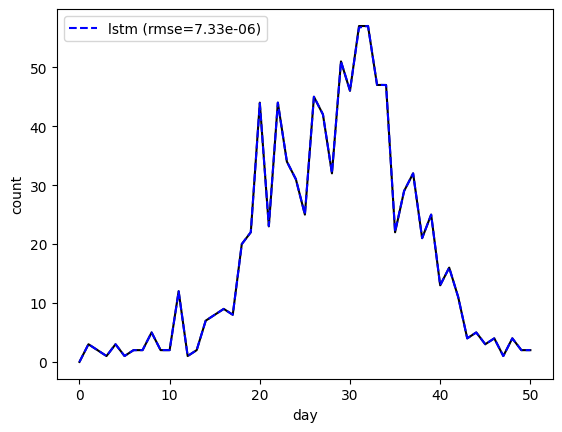

In [24]:
plt.plot(range(len(y_train_detach)), y_train_detach, color='black')
plt.plot(range(len(y_pred_detach)), y_pred_detach, 'b--', label='lstm (rmse={rmse:.2e})'.format(rmse=mse / np.var(y_train_detach)))
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()